# Chapter 17. 表示学习以及基于自编码器和GANs的生成学习

自编码器（Autoencoder， AE）是一种基于无监督模式，学习输入数据的紧密表示的一种人工神经网络（ANN），学习出的紧密表示又被称为“隐含表示（latent representations）”或“隐含编码(latent codings)”。这些编码通常相对输入数据有着更低的维度，因此自编码器可以作为一种降维工具（第8章）。此外，自编码器也具备特征解码的能力，可用于深度神经网络（DNN）的预训练（第11章）。同时，一些自编码器也被作为生成模型：用于生成与输入数据类似的新数据。例如，将面部图片作为输入，自编码器可以生成新的面部图片数据，尽管这些新生成的数据往往比较模糊而不完全真实。

相比之下，生成对抗网络（Generative adversial networks,GANs）生成的面部图片看起来会更加真实。GANs现在被广泛用于超分辨率（增加图片分辨率），和图片着色。

AE和GANs均是无监督模型，可以用于生成数据的紧密表示，可以作为生成模型，因此它们在应用方面是类似的。然而，在作用机理方面，两者存在较大不同：

1. AE的学习任务是仅仅保证模型输出尽可能与模型输入相同。这听起来是一个非常普通的任务，但是在给网络添加各种约束的过程中会出现很多困难。例如， 限制中间表示的大小，或者向输入数据添加噪声并期望输出未加噪声的原始数据。这些约束会防止网络仅仅将输入复制到输出以完成任务，从而迫使网络学习出更高效的数据表示方式。换句话说，隐含编码仅仅是AE在一些约束下学习数据的identity函数时产生的副产品。

2. GANs由两部分神经网络组成：生成器(generater)，用于生成类似于训练数据的数据；识别器(discriminator)，用于识别真实数据与生成器生成的假数据。对抗学习被认为是近些年最杰出的思想之一。

这一章我们将首先挖掘AE的工作机理以及其在降维，特征提取，无监督训练，以及作为生成模型等方面的应用。然后再讨论GANs，包括训练的示例，训练过程会遭遇的困难，以及一些主要的解决方案。

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# if not tf.config.list_physical_devices('GPU'):
#     print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
#     if IS_COLAB:
#         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

## 高效的数据表示

以下两个数据序列哪个更容易记忆？

- 40, 27, 25, 36, 81, 57, 10, 73, 19, 68

- 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14

乍一看似乎第一个序列更容易记忆，因为更短。但是仔细观察后发现第二个序列具有清晰的模式：从50到14的差为2的等差数列。

在20世纪70年代，William Chase和 Herbert Simon关于记忆，感知以及模式匹配有着著名的研究。他们发现专业棋手可以轻松记忆棋盘上棋子的位置，但前提是棋子的位置是正在进行的棋局而不是随意摆放的。这是因为专业棋手的丰富经验，使得他们更容易发现棋盘上的模式。

类似的，自编码器就可以发现输入数据的模式并得到高效的隐含表示，然后再给出一个接近于输入的输出。自编码器一般由两部分组成：一个编码器，以及一个解码器。其中编码器负责将输入转化为隐含表示；而后接的解码器则负责将隐含表示转化为接近输入的输出。

自编码器的网络结构与多层感知器(MLP;参见第10章)类似，但自编码器输出层与输入层的神经元数目必须相等，这是自编码器的数据重构功能决定的。同时，自编码器的重构功能也决定了模型的损失函数一般要包含重构损失，从而在重构数据不同于输入数据时对模型进行惩罚。

因为隐含表示通常比输入数据具有更低的维度，所以自编码器被认为是“欠完备”的。一个欠完备的自编码器不能简单地将输入复制到编码，它必须找到一种方法来尽量表示输入数据，因此它将被迫学习输入数据中最重要的特征(并剔除不重要的特征)。

接下来我们在降维任务中实现一个简单的autoencoder。

## 利用“欠完备”的线性自编码器实现PCA

### 自编码器

自编码器采用线性激活和均方误差（MSE），然后进行主成分分析。以下代码实现了一个3D数据到2D数据的降维：

In [2]:
from tensorflow import keras
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=
[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=
[2])])
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.1))

上述代码与我们上一章实现的MLP差别不大，但有几点需要注意：

- 我们将自编码器分成两个组件实现：编码器和解码器。两者都使用常规的$\textsf{ Sequential}$模型并各带一个$\textsf{Dense}$层。

- 自编码器输入与输出的神经元数目相同。

- 为了实现PCA，我们不添加激活函数（即，所有的神经元都是线性的），损失函数设置为均方误差MSE。后续我们会接触到更复杂的损失函数设定。

接下来我们在一个生成的3D数据集上训练自编码器，并使用其对该3D数据集进行编码（比如，映射到2维）：

Train on 60 samples
Epoch 1/20
60/60 [==============================] - 0s 133us/sample - loss: 0.0064
Epoch 2/20
60/60 [==============================] - 0s 50us/sample - loss: 0.0064
Epoch 3/20
60/60 [==============================] - 0s 49us/sample - loss: 0.0063
Epoch 4/20
60/60 [==============================] - 0s 50us/sample - loss: 0.0063
Epoch 5/20
60/60 [==============================] - 0s 50us/sample - loss: 0.0063
Epoch 6/20
60/60 [==============================] - 0s 50us/sample - loss: 0.0063
Epoch 7/20
60/60 [==============================] - 0s 66us/sample - loss: 0.0063
Epoch 8/20
60/60 [==============================] - 0s 66us/sample - loss: 0.0062
Epoch 9/20
60/60 [==============================] - 0s 66us/sample - loss: 0.0062
Epoch 10/20
60/60 [==============================] - 0s 67us/sample - loss: 0.0062
Epoch 11/20
60/60 [==============================] - 0s 66us/sample - loss: 0.0062
Epoch 12/20
60/60 [==============================] - 0s 50us/sample - loss:

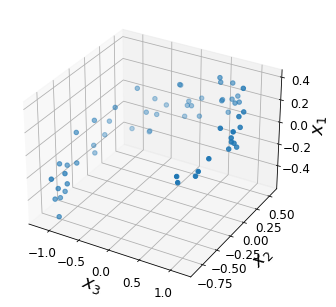

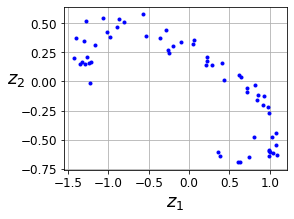

In [22]:
#生成3D数据集
from mpl_toolkits.mplot3d import Axes3D

def plot_3D(data):
    x = data[:, 0] 
    y = data[:, 1]  
    z = data[:, 2]  
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z)
    ax.set_zlabel("$x_1$", fontdict={'size': 18})
    ax.set_ylabel("$x_2$", fontdict={'size': 18})
    ax.set_xlabel("$x_3$", fontdict={'size': 18})
    plt.show()
    
np.random.seed(4)
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

history = autoencoder.fit(X_train, X_train, epochs=20)
codings = encoder.predict(X_train)


plot_3D(X_train)

fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1],'b.')
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
# save_fig("linear_autoencoder_pca_plot")
plt.show()

注意相同的数据集$\textsf{X_train}$被同时设定为训练输入和训练目标。上图展示了原始的3D数据集（图上），以及利用自编码器生成的2维编码（图下）。不难发现，自编码器成功找到了最适合原始数据的2维平面，即尽量保留了数据中最大的方差（就像PCA）。

### Stacked Autoencoders

与一般的神经网络类似，自编码器同样可以具备多个隐含层，这种情况下的自编码器被称为“stacked autoencoders(或者 deep autoencoders)”。虽说增加隐含层理论上会帮助自编码器学习更复杂的编码，但是我们必须注意控制自编码器的编码能力。想象一个足够强大的encoder，其可以将训练集的输入数据都各自映射到一个任意的数字，而decoder可以学习出对应的逆映射将数字映射到数据。这样的自编码器可以完美地重构输入数据，但是其不具备任何的泛化能力，即无法在新数据上有好的表现。

stacked autoencoders的架构通常关于最中间的编码层是对称的，简单来讲就是一个三明治结构。例如对于mnist数据集，我们构建一个encoder, 其输入维度是$28\times 28=784$，中间的编码层维度设置为30，在输入层与编码层之间存在一个100维的隐含层；decoder的结构与其对称。如下图所示：
![stacked ae.png](https://raw.githubusercontent.com/private-mechanism/book_translation/master/images/autoencoders/stacked%20autoencoders.png)

#### 利用Keras实现Stacked Autoencoders

我们可以像实现一个深层MLP一样来实现Stacked Autoencoders。具体的，我们可以使用在第11章训练深度网络时相同的技术。例如，下列代码利用SELU激活函数针对Fashion mnist数据集建立了一个Stacked Autoencoder：

In [3]:
#加载fashion-mnist数据集
# from keras.datasets import fashion_mnist
# (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [4]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]), keras.layers.Dense(100, activation="selu"), keras.layers.Dense(30, activation="selu"),])
stacked_decoder = keras.models.Sequential([keras.layers.Dense(100, activation="selu", input_shape=[30]),keras.layers.Dense(28 * 28, activation="sigmoid"),keras.layers.Reshape([28, 28])])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
history = stacked_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 31s 564us/sample - loss: 0.3376 - val_loss: 0.3113
Epoch 2/10
55000/55000 [==============================] - 35s 638us/sample - loss: 0.3053 - val_loss: 0.3027
Epoch 3/10
55000/55000 [==============================] - 68s 1ms/sample - loss: 0.2988 - val_loss: 0.2980
Epoch 4/10
55000/55000 [==============================] - 57s 1ms/sample - loss: 0.2950 - val_loss: 0.2982
Epoch 5/10
55000/55000 [==============================] - 52s 953us/sample - loss: 0.2923 - val_loss: 0.2934
Epoch 6/10
55000/55000 [==============================] - 48s 878us/sample - loss: 0.2905 - val_loss: 0.2919
Epoch 7/10
55000/55000 [==============================] - 67s 1ms/sample - loss: 0.2890 - val_loss: 0.2892
Epoch 8/10
55000/55000 [==============================] - 58s 1ms/sample - loss: 0.2878 - val_loss: 0.2884
Epoch 9/10
55000/55000 [==============================] - 45s 827us/sample - loss: 0.28

代码注释： 
- 首先设置自编码器的两个子结构：编码器以及解码器。

- 编码器的输入为28×28像素的灰度图像,这些图像首先被拉平为784维的向量,然后通过两个维度递减的全连接层(100维到30维)来处理这些向量,隐含层都使用SELU激活函数(您可能希望添加LeCun初始化,但网络不是很深,所以它不会产生很大的影响)。对于每个输入图像，编码器输出一个维度为30的向量。

- 解码器以编码器输出的30维向量做为输入，并采用与编码器对称的网络结构。

- 我们使用二元交叉熵损失作为Stacked Autoencoder的损失函数。具体的，我们将重构任务作为多标签的分类任务，其中每个像素的强度代表了该像素是黑色的概率。相比于将问题视作回归问题，这样将问题视为分类问题会使得模型收敛更快。

- 最终，我们将X_train数据同时作为输入数据和重构目标（类似的，我们将X_valid同时作为验证的输入数据和重构目标）。

#### 重构数据的可视化

最直观评估自编码器性能的方法是比较输入和输出：输入数据与重构数据的差异应该并不显著。我们可视化出验证集中的部分图像数据以及对应的重构数据。

In [10]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


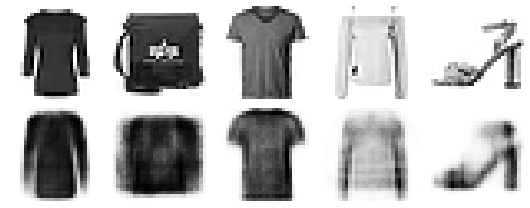

In [9]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

可以看出，重构数据可以辨认，但还是有些模糊。一个很自然的想法是：如果把训练时间设置的更长，编码器和解码器设置的更深，或者让编码长度更长，图片会不会更加清晰呢。注意：如果通过这些方式使得网络能力过强，自编码器有可能在没学习出任何有用模式的条件下完美地重构数据，但这样的自编码器是无价值的。

#### 可视化 Fashion MNIST数据集 

Stacked autoencoder可用于数据集的降维。事实上，与之前讨论的其他降维算法(第8章)相比，自编码器的可视化效果并不突出，其真正的优势在于可以处理具有许多样本和特征的大型数据集。因此我们考虑首先使用自编码器将大型数据集维度降低到合理水平，然后再使用另一个降维算法进行可视化。接下来，我们使用这个策略可视化Fashion MNIST数据集：首先使用stacked autoencoder中的编码器将数据集维度降到30，然后使用Scikit-Learn包中的t-SNE降维算法进一步将维度降低到2，以便进行可视化:

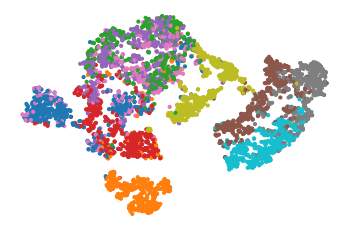

In [10]:
# %matplotlib notebook
np.random.seed(42)
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())


plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

进一步优化可视化结果：

Saving figure fashion_mnist_visualization_plot


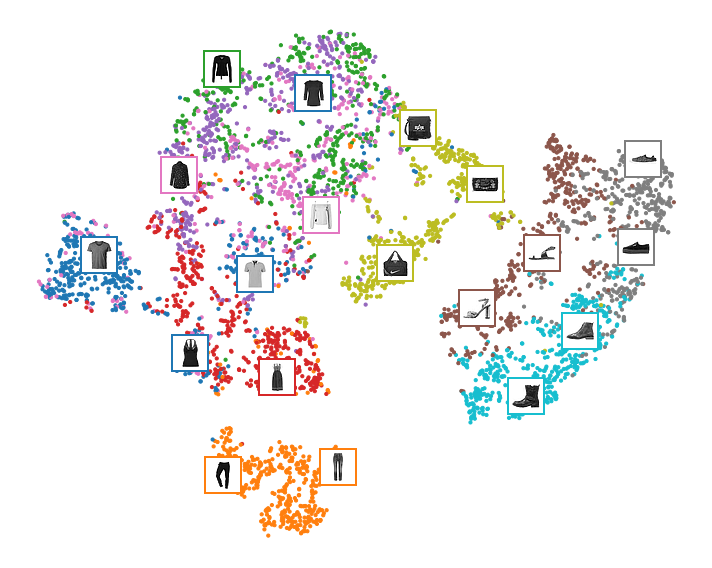

In [11]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

如图，t-SNE算法可以在自编码器降维后的数据上准确识别每一个类（每一个颜色代表了不同的类别）。可见，自编码器可以用于降维和可视化任务。另一个典型的应用是无监督的预训练。

#### 使用Stacked Autoencoder进行无监督的预训练

我们已经在第11章讨论过，在缺乏标注数据时，一个好的解决方案是寻找一个在类似任务上表现优秀的网络，并重复利用其浅层网络。这使它可以用少量的训练数据来训练一个高性能的模型，因为你的神经网络不需要学习所有的底层特征：只需要重用已有网络的特征提取器即可。

类似的，如果有大量未标注数据以及少量标注数据，我们可以首先利用所有数据训练一个Stacked Autoencoder，并利用其浅层网络和标注数据来训练网络实现任务。例如，下图展示了如何利用Stacked Autoencoder来为分类神经网络进行无监督的预训练。当训练分类器时，如果没有足够的标注数据，那么最好能够通过预训练得到并固定一些浅层的特征提取器。


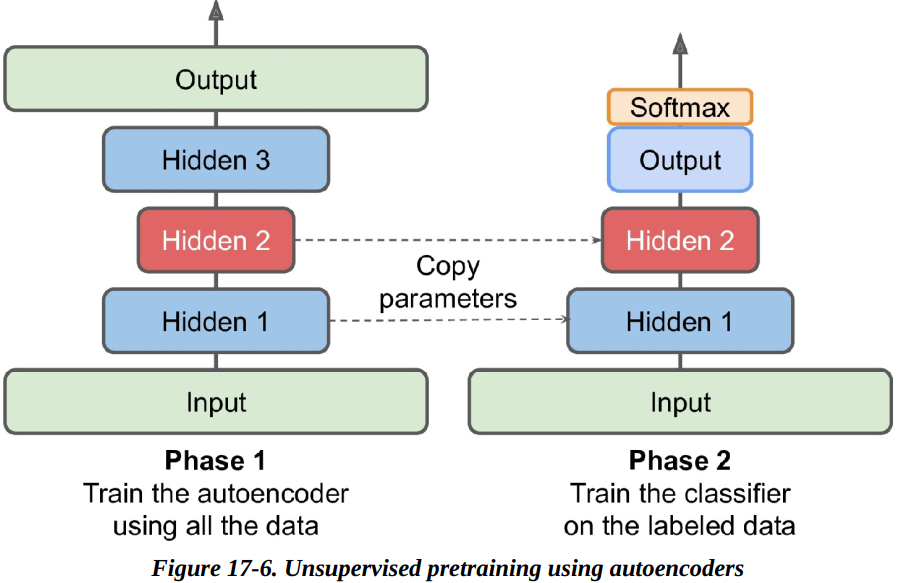

接下来，我们介绍一些训练Stacked Autoencoder的技巧。

#### 训练技巧1： 绑定权重 （Tying weights）

如果一个自编码器是整齐对称的，那么一个常用的技巧是将decoder与encoder的权重参数绑定。这使得模型中的权重减半，加快了训练速度，限制了过度拟合的风险。具体来说，如果自编码器共有N个层(不包括输入层)，W表示第L层的连接权值(如第1层是第一个隐含层，第$N/2$层是编码层，第$N$层为输出层)，那么整个解码器层的权重可以被简单定义为：$W_{N-L+1}=W_{L}^\top$，其中$L=1,2,...,\frac{N}{2}$.

为了使用Keras来绑定不同层的权重，我们定义一个自定义层 (custom layer)：

In [12]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

这个自定义层的作用与常规的全连接层类似，但是它使用了另一个全连接层的权重和自身的偏置向量。接下来，我们可以建立一个新的stacked autoencoder，与之前那个类似，但是这个自编码器中解码器的全连接层参数与编码器的全连接层参数是绑定在一起的。

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 94s 2ms/sample - loss: 0.3269 - rounded_accuracy: 0.8959 - val_loss: 0.3025 - val_rounded_accuracy: 0.9192
Epoch 2/10
55000/55000 [==============================] - 117s 2ms/sample - loss: 0.2973 - rounded_accuracy: 0.9225 - val_loss: 0.2951 - val_rounded_accuracy: 0.9234
Epoch 3/10
55000/55000 [==============================] - 94s 2ms/sample - loss: 0.2915 - rounded_accuracy: 0.9280 - val_loss: 0.2921 - val_rounded_accuracy: 0.9261
Epoch 4/10
55000/55000 [==============================] - 75s 1ms/sample - loss: 0.2885 - rounded_accuracy: 0.9305 - val_loss: 0.2882 - val_rounded_accuracy: 0.9324
Epoch 5/10
55000/55000 [==============================] - 90s 2ms/sample - loss: 0.2863 - rounded_accuracy: 0.9326 - val_loss: 0.2889 - val_rounded_accuracy: 0.9274
Epoch 6/10
55000/55000 [==============================] - 94s 2ms/sample - loss: 0.2849 - rounded_accuracy: 0.9338 - val_loss

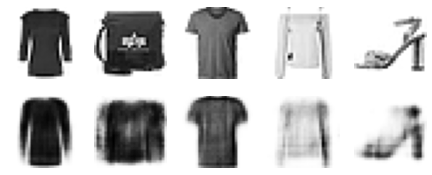

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))
show_reconstructions(tied_ae)
plt.show()

由图可以看出，这个模型与之前的模型相比，仅仅使用一半的参数就实现了更低的重构误差。

#### 训练技巧2：一次训练一个自编码器

与其一次性训练整个Stacked Autoencoder，不如一次仅仅训练一个浅层的自编码器，然后再将这些浅层的自编码器堆叠为一个Stacked Autoencoder。这个技巧在最新的研究中出现的不算很多，但是在一些文章中还是会出现“greedy layer training”的说法，因此对其充分理解是必要的。

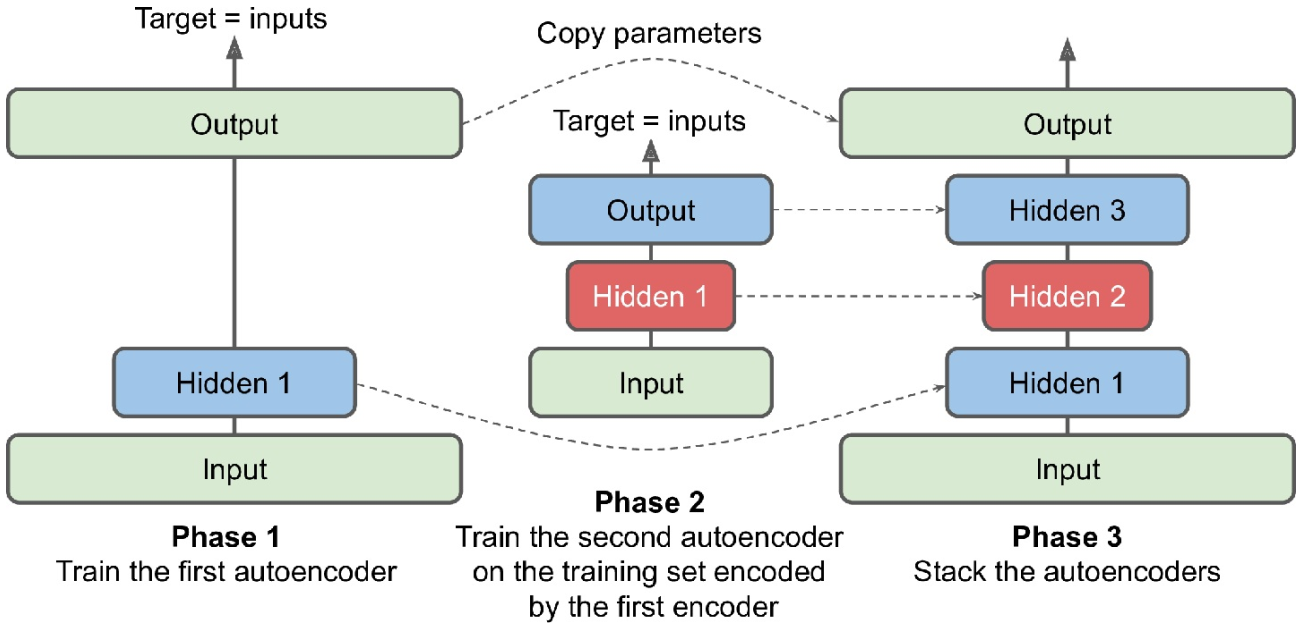

在训练的第一阶段，第一个自编码器首先学习对输入数据进行重构，然后对整个数据集进行编码，这就生成了一个新的(压缩的)数据集。在训练的第二阶段，我们在这个新的压缩数据集上训练第二个自编码器，训练目标还是进行数据重构。最后，我们将所有训练的自编码器构建成一个大的“三明治”结构，如上图所示。这样我们就得到了最终的stacked autoencoder。我们可以使用这种方法训练很多个自编码器，从而构建出一个非常深的stacked autoencoder。

正如我们前面所讨论的，目前人们对深度学习的巨大兴趣之一是2006年Geoffrey Hinton等人的发现：通过这种greedy layer training的方法，可以在无监督的情况下对深度神经网络进行预训练。他们当时使用受限玻尔兹曼机(RBMs）完成这个预训练任务；但在2007年，Yoshua Bengio等人证明了自编码器也能起到同样的效果。很多年以来，这是训练深度网络的唯一有效方法，直到我们在第11章中介绍的许多技术才使一次性训练深度网络成为可能。

自编码器不仅仅可以利用全连接神经网络来建立，也可以使用卷积神经网络，甚至循环神经网络。

## 卷积自编码器 (Convolutional Autoencoders)

目前我们所展示的几个自编码器并不能很好的处理图片数据：就像在第14章我们发现，卷积神经网络相比于全连接网络更加适合于处理图片数据。因此，我们可以建立一个针对图片数据的卷积自编码器（进行降维或者无监督学习)。其中，编码器采用由卷积层和池化层组合成的CNN，负责降低输入数据的空间维度（如：高度和宽度）同时增加图片深度（如：特征图的数目）。而解码器则负责相反的任务（如: 扩展图片的维度并将其深度降低到原始的维度)，因此，我们可以采用转置卷积层（也可以结合上采样层和卷积层来代替）。以下是一个针对Fashion MNIST数据的卷积自编码器：

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 56s 1ms/sample - loss: 0.3020 - rounded_accuracy: 0.9186 - val_loss: 0.2800 - val_rounded_accuracy: 0.9395
Epoch 2/5
55000/55000 [==============================] - 55s 992us/sample - loss: 0.2755 - rounded_accuracy: 0.9414 - val_loss: 0.2731 - val_rounded_accuracy: 0.9454
Epoch 3/5
55000/55000 [==============================] - 52s 939us/sample - loss: 0.2707 - rounded_accuracy: 0.9463 - val_loss: 0.2703 - val_rounded_accuracy: 0.9477
Epoch 4/5
55000/55000 [==============================] - 58s 1ms/sample - loss: 0.2681 - rounded_accuracy: 0.9491 - val_loss: 0.2676 - val_rounded_accuracy: 0.9515
Epoch 5/5
55000/55000 [==============================] - 53s 969us/sample - loss: 0.2663 - rounded_accuracy: 0.9510 - val_loss: 0.2678 - val_rounded_accuracy: 0.9516
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output S

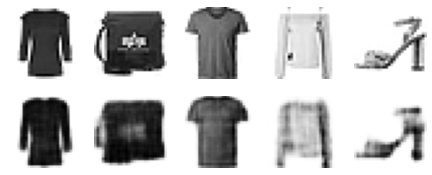

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))
conv_encoder.summary()
conv_decoder.summary()
show_reconstructions(conv_ae)
plt.show()

## 循环自编码器 (Recurrent Autoencoders)

如果我们想建立一个处理序列化数据的自编码器，比如时间序列数据或者文本数据，RNN相比于全连接神经网络是更好的选择。建立一个循环自编码器是直接的：编码器通常是一个基于sequence-to-vector的RNN用于将输入序列压缩到一个单一向量。解码器则是一个负责相反任务的基于sequence-to-vector的RNN。

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 198s 4ms/sample - loss: 0.5186 - rounded_accuracy: 0.7500 - val_loss: 0.4567 - val_rounded_accuracy: 0.8082
Epoch 2/10
55000/55000 [==============================] - 186s 3ms/sample - loss: 0.4044 - rounded_accuracy: 0.8435 - val_loss: 0.3748 - val_rounded_accuracy: 0.8683
Epoch 3/10
55000/55000 [==============================] - 185s 3ms/sample - loss: 0.3650 - rounded_accuracy: 0.8713 - val_loss: 0.3581 - val_rounded_accuracy: 0.8746
Epoch 4/10
55000/55000 [==============================] - 183s 3ms/sample - loss: 0.3507 - rounded_accuracy: 0.8810 - val_loss: 0.3461 - val_rounded_accuracy: 0.8847
Epoch 5/10
55000/55000 [==============================] - 178s 3ms/sample - loss: 0.3403 - rounded_accuracy: 0.8880 - val_loss: 0.3380 - val_rounded_accuracy: 0.8882
Epoch 6/10
55000/55000 [==============================] - 186s 3ms/sample - loss: 0.3333 - rounded_accuracy: 0.8925 - val

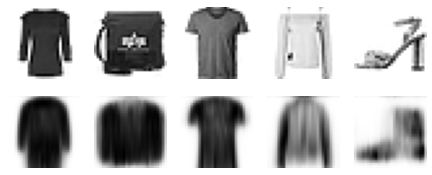

In [24]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
show_reconstructions(recurrent_ae)
plt.show()

这个循环自编码器可以处理任意长度的序列数据，每一步处理28个维度。这就意味着它在处理Fashion MNIST数据时，是将图片数据视作一行行的像素数据进行处理的，每行由28个像素组成注意我们使用一个$\textsf{RepeatVector}$层作为解码器的第一层，这可以保证每一步都有28个像素组成的数据被输入解码器。

目前为止，我们已经学习了多种自编码器的结构，以及训练它们的方法（一次性或者一层一层训练）。我们同样也看到了两个典型的应用：数据可视化以及无监督学习。

但是这些自编码器中的编码层维度都是小于实际的数据维度的，这样的编码器成为“欠完备的（undercomplete）”。事实上，还存在编码层维度大于实际数据维度的自编码器，这样的自编码器称为“过完备的”。

## 降噪自编码器 (Denoising Autoencoders)

另一种迫使自编码器学习有效特征的方法是向输入数据中添加噪声，再训练自编码器输出与噪声无关的输入数据。这个想法在20世纪80年代就已经被LeCun的一名硕士提出了。在2008年的一篇文章中，Vincent引入了堆叠降噪自编码器(stacked denoising autoencoders)。

在堆叠降噪自编码器中，可以通过向输入添加纯粹的高斯噪声，也可以随机剪除输入数据的部分信息（类似于dropout）来实现加噪的目的。下图展示了这两种方案：

![denoising.png](https://raw.githubusercontent.com/private-mechanism/book_translation/master/images/autoencoders/denoising%20autoencoders.png)

降噪自编码器的实现是直接的：直接向stacked autoencoder添加一个dropout层（或者高斯噪声层）作用于输入数据即可。注意，不论drop层还是高斯噪声层，都只在训练过程中发挥作用。

In [17]:
#添加高斯噪声，而不采用dropout
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=5,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 76s 1ms/step - loss: 0.3496 - rounded_accuracy: 0.8780 - val_loss: 0.3207 - val_rounded_accuracy: 0.9078
Epoch 2/5
55000/55000 [==============================] - 72s 1ms/step - loss: 0.3120 - rounded_accuracy: 0.9100 - val_loss: 0.3073 - val_rounded_accuracy: 0.9153
Epoch 3/5
55000/55000 [==============================] - 80s 1ms/step - loss: 0.3052 - rounded_accuracy: 0.9157 - val_loss: 0.3022 - val_rounded_accuracy: 0.9198
Epoch 4/5
55000/55000 [==============================] - 77s 1ms/step - loss: 0.3012 - rounded_accuracy: 0.9192 - val_loss: 0.2985 - val_rounded_accuracy: 0.9236
Epoch 5/5
55000/55000 [==============================] - 75s 1ms/step - loss: 0.2985 - rounded_accuracy: 0.9215 - val_loss: 0.2969 - val_rounded_accuracy: 0.9236


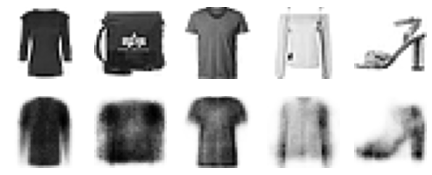

In [18]:
tf.random.set_seed(42)
np.random.seed(42)
noise = keras.layers.GaussianNoise(0.2)
# show_reconstructions(denoising_ae, noise(X_valid, training=True))
show_reconstructions(denoising_ae)
plt.show()

In [15]:
#采用dropout
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=5,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 80s 1ms/step - loss: 0.3564 - rounded_accuracy: 0.8716 - val_loss: 0.3205 - val_rounded_accuracy: 0.9037
Epoch 2/5
55000/55000 [==============================] - 109s 2ms/step - loss: 0.3189 - rounded_accuracy: 0.9024 - val_loss: 0.3118 - val_rounded_accuracy: 0.9102
Epoch 3/5
55000/55000 [==============================] - 72s 1ms/step - loss: 0.3128 - rounded_accuracy: 0.9072 - val_loss: 0.3071 - val_rounded_accuracy: 0.9147
Epoch 4/5
55000/55000 [==============================] - 73s 1ms/step - loss: 0.3092 - rounded_accuracy: 0.9101 - val_loss: 0.3042 - val_rounded_accuracy: 0.9158
Epoch 5/5
55000/55000 [==============================] - 90s 2ms/step - loss: 0.3066 - rounded_accuracy: 0.9123 - val_loss: 0.3029 - val_rounded_accuracy: 0.9196


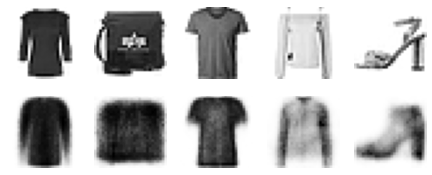

In [16]:
tf.random.set_seed(42)
np.random.seed(42)
dropout = keras.layers.Dropout(0.5)
# show_reconstructions(dropout_ae, dropout(X_valid, training=True))
show_reconstructions(dropout_ae)
plt.show()

如图展示了一些噪声图片（一半像素被移除）以及被基于dropout的降噪自编码器重构的图片数据。如图所示，降噪自编码器可以猜测出输入数据的一部分细节，比如T恤衫的高度（图中第2行第4张图片）。如此看来，降噪自编码器不仅仅可以实现传统自编码器数据可视化，无监督预训练等任务外，还可以简单高效地移除图像中的噪声。

## 稀疏自编码器 (Sparse Autoencoders)

还有一种有利于提取特征的办法是增加稀疏性：通过向损失函数添加合适的项，自编码器在编码层被激活神经元的个数将被迫降低。例如，大约只有5%的编码层神经元可以保持激活状态。这会迫使自编码器以更加稀释的编码来表示出原始数据的信息，这样的好处在于每一个激活神经元的输出都会更有价值（想象你每个月只能说一句话，那么你一定会最大化这句话的价值）。

一个简单的办法是在编码层使用sigmoid激活函数（保持每个编码层神经元的输出保持在0到1之间），增加编码层神经元个数（300个左右），并且向编码层的激活函数添加$L_1$正则化项。解码器还是常规的解码器。

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # 等价的，我们可以移除这一层并在上一层添加activity_regularizer=keras.regularizers.l1(1e-3)
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 64s 1ms/sample - loss: 0.4307 - rounded_accuracy: 0.8133 - val_loss: 0.3801 - val_rounded_accuracy: 0.8590
Epoch 2/10
55000/55000 [==============================] - 61s 1ms/sample - loss: 0.3691 - rounded_accuracy: 0.8690 - val_loss: 0.3644 - val_rounded_accuracy: 0.8715
Epoch 3/10
55000/55000 [==============================] - 55s 998us/sample - loss: 0.3554 - rounded_accuracy: 0.8789 - val_loss: 0.3530 - val_rounded_accuracy: 0.8764
Epoch 4/10
55000/55000 [==============================] - 61s 1ms/sample - loss: 0.3442 - rounded_accuracy: 0.8870 - val_loss: 0.3426 - val_rounded_accuracy: 0.8881
Epoch 5/10
55000/55000 [==============================] - 70s 1ms/sample - loss: 0.3368 - rounded_accuracy: 0.8926 - val_loss: 0.3412 - val_rounded_accuracy: 0.8957
Epoch 6/10
55000/55000 [==============================] - 67s 1ms/sample - loss: 0.3307 - rounded_accuracy: 0.8981 - val_los

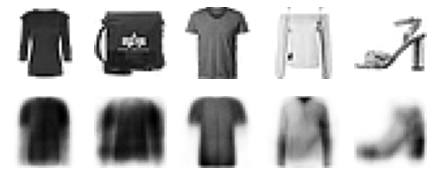

In [8]:
show_reconstructions(sparse_l1_ae)
plt.show()

这里的$\textsf{ActivityRegularization}$层仅仅返回了自己的输入，但作为副作用它添加了一个等于自身输入的绝对值和的训练损失（这一层只在训练过程中起作用）。等价的，我们也可以移除$\textsf{ActivityRegularization}$层，同时在前一层设置$\textsf{activity_regularizer=keras.regularizers.l1(1e-3)}$。这个惩罚将促使神经网络生成的编码接近于0，但是这会反过来引发重构误差的惩罚，因为接近于0的编码无法很好的还原输入数据，因此编码中即使稀疏但还是会出现一些非0项。使用$L_1$正则化方法将会促使自编码器保留最重要的编码同时移除部分对还原输入数据不重要的编码。

另一种通常会产生更好结果的方法是在每次训练迭代中度量编码层的实际稀疏度，当度量的稀疏度与目标稀疏度不同时则对模型进行惩罚。而实际稀疏度可以通过计算整个训练过程中编码层每个神经元的平均激活率来度量，此时为了平均值的准确性，批次大小不能太小。

一旦我们有了每个神经元的平均激活率，就可以惩罚那些表现太活跃的神经元，或者那些太沉寂的神经元。方法是向损失函数添加稀疏损失。例如，如果我们度量出目前神经元的平均激活率为0.3，而目标激活率是0.1，那么我们就需要施加惩罚来降低激活率。一个简单的实现方法是将平方误差$(0.3-0.1)^2$添加到损失函数，但事实上最好的办法是添加KL-散度，KL-散度是一个比均方误差可以产生更“强”的梯度的误差项，如下图所示。

![spasityloss.png](https://raw.githubusercontent.com/private-mechanism/book_translation/master/images/autoencoders/Sparsity%20loss.png)

给定两个离散分布$P$和$Q$，它们之间的KL-散度$D_{KL}(P|Q)$可以按下式计算。

$D_{KL}(P|Q)=\sum_{i}P_{i}\log{\frac{P_{i}}{Q_{i}}}$

在我们的场景当中，我们想要度量编码层一个神经元激活的目标概率$p$与实际概率$q$之间的KL-散度（如，训练批次上的平均激活率）。此时KL-散度的计算可以进一步简化：

$D_{KL}(p|q)=p\log{\frac{p}{q}+(1-p)\log{\frac{1-p}{1-q}}}$

一旦我们计算出了编码层每个神经元的稀疏损失，我们可以将这些损失加起来然后添加到损失函数上。为了控制稀疏损失与重构损失的相对重要性，我们可以向稀疏损失乘以一个代表稀疏性权重的超参数。如果这个权重太高的话，模型将会偏向将编码稀疏化到目标程度而牺牲一定的数据重构精度。反过来，如果权重过低的话，模型会忽略稀疏度的需求而不能学习出有足够价值的特征。

现在我们建立一个KL-正则化类用于实现基于KL-正则化的激活函数。

In [21]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

下面构建稀疏自编码器，向每个编码层神经元的激活函数添加KL-散度正则化项。

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 125s 2ms/sample - loss: 0.4151 - rounded_accuracy: 0.8121 - val_loss: 0.3715 - val_rounded_accuracy: 0.8569
Epoch 2/10
55000/55000 [==============================] - 103s 2ms/sample - loss: 0.3532 - rounded_accuracy: 0.8762 - val_loss: 0.3443 - val_rounded_accuracy: 0.8845
Epoch 3/10
55000/55000 [==============================] - 113s 2ms/sample - loss: 0.3339 - rounded_accuracy: 0.8920 - val_loss: 0.3292 - val_rounded_accuracy: 0.8964
Epoch 4/10
55000/55000 [==============================] - 97s 2ms/sample - loss: 0.3222 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9046
Epoch 5/10
55000/55000 [==============================] - 97s 2ms/sample - loss: 0.3169 - rounded_accuracy: 0.9062 - val_loss: 0.3173 - val_rounded_accuracy: 0.9061
Epoch 6/10
55000/55000 [==============================] - 91s 2ms/sample - loss: 0.3135 - rounded_accuracy: 0.9093 - val_lo

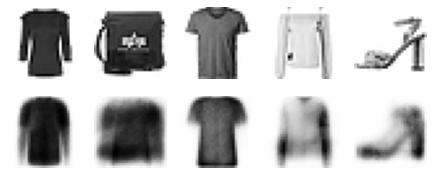

In [28]:
show_reconstructions(sparse_kl_ae)

In [29]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Saving figure sparse_autoencoder_plot


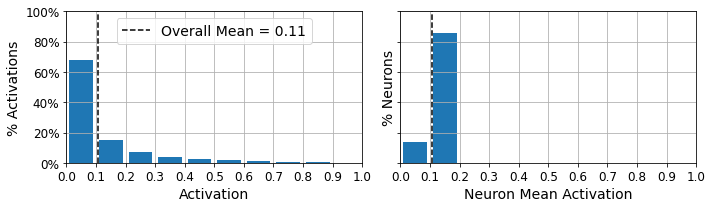

In [33]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

如下图所示，在Fashion MNIST数据集上训练稀疏自编码器，编码层神经元的激活函数值几乎趋向于0（大约70%的神经元的激活函数值都低于0.1），并且所有神经元的平均激活函数值在0.1左右（90%神经元的激活函数值在0.1到0.2之间）。

## 变分自编码器 (Variational Autoencoders)

自编码器的另一个重要的类别是变分自编码器（VAE），于2013年由Diederik Kingma 以及 Max Welling提出。VAE一经提出，便迅速成为最流行的自编码器。VAE与我们之前讨论的自编码器由很大的不同，主要体现在以下几个方面：

- VAE是概率自编码器,这意味着它们的输出有一部分是取决于随机性的，即使在训练后（这不同于降噪自编码器，仅仅在训练过程中会利用随机性）。
- 更重要的是，VAE可以生成一些新的样本，这些样本与训练集的数据有相似的特征。

这两个特征赋予VAE与受限玻尔兹曼机(RBMs)类似的性质，但是VAE相比RBMs更容易训练，采样过程也更高效（在RBMs中，我们需要等待网络稳定到某一个“热力学状态”才能进行采样）。事实上，VAE的本质是对数据的分布进行变分贝叶斯推理（变分贝叶斯推理是一种进行逼近贝叶斯推理的典型方法）。

我们简单看一下VAE的作用机理。如下图所示，图左展示了VAE的基本结构，与传统自编码器一致，VAE也包含一个编码器, 以及一个解码器(图例中均由两个隐含层构成)。但有一点不同，传统自编码器是直接生成编码的，而VAE会首先生成一个高斯分布的均值$\mu$和标准差$\sigma$，而编码则是从这个高斯分布$N(\mu,\sigma)$中随机采样生成的。之后的解码过程与传统自编码器一致。图右显示了VAE的一个训练实例：输入数据首先由编码器处理，生成均值$\mu$和标准差$\sigma$，然后从$N(\mu,\sigma)$中随机采样生成编码，最后对编码进行解码使得最终的输出与输入数据相近。
![VAE.png](https://raw.githubusercontent.com/private-mechanism/book_translation/master/images/autoencoders/VAE.png)

如上图所示，尽管输入数据的分布非常复杂，VAE仍使用非常简单的采样方法（从简单的高斯分布中采样）来生成编码：在训练过程当中，通过损失函数的指引，隐含编码会逐渐趋近于一团服从于高斯分布的点。这样有一个巨大的好处是在生成一个新样本的时候，只需要从高斯分布中随机采样一个点，然后再解码就可以了。

现在，我们关注损失函数。损失函数由两部分组成。第一部分是重构损失：输入数据与模型输出之间的误差，大多数情况下采用的是交叉熵。另一部分是隐含损失：生成的高斯分布与实际的编码分布之间的误差，一般用KL-散度来衡量。隐含损失的表达式如下：

$L=-\frac{1}{2}\sum_{i=1}^{K}1+\log(\sigma_{i}^2)-\sigma_{i}^2-\mu_{i}^2$

在等式中，$L$是隐含损失，$n$是编码的维度，$\mu_i$和$\sigma_{i}$分别是编码的第$i$个元素的均值和标准差。而向量$\mu$和$\sigma$（包含了所有的$\mu_i$和$\sigma_i$）则是编码器的输出。

关于VAE架构的一个通用的变体是使得编码器的输出$\gamma=\log(\sigma^2)$而不是$\sigma$（简便起见，以下称该变体为$\gamma$变体）。这种情况下隐含损失可以通过以下等式计算，这种方法相对来说更加稳定也能够加速训练。

$L=-\frac{1}{2}\sum_{i=1}^{K}1+\gamma_{i}-\exp{{\gamma_i}}-\mu_{i}^2$

接下来为Fashion MNIST数据集搭建一个基于$\gamma$变体的VAE。首先，我们需要一个定制层来在给定$\mu$和$\gamma$的情况下采样编码;

In [31]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

这个$\textsf{Sampling}$层的输入为：$mean(\mu)$和$log{\_}{var}(\gamma)$。它采用函数$\textsf{K.random_normal()}$从标准正态分布（均值为0，方差为1）中采样出一个随机变量（与$\gamma$同样的形状），然后再对该向量乘以$\exp(\gamma/2)$，最终再添加$\mu$并返回结果。这样就从均值为1，标准差为$\sigma$的正态分布中采样出了随机向量。

接下来，我们可以创建编码器，代码中使用了Functional API，因为模型不完全是序列化的：

In [32]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

注意，上述代码中分别负责输出$\textsf{codings_mean}(\mu)$和$\textsf{codings_log_var}(\gamma)$的$Dense$层有着相同的输入。我们将$\textsf{codings_mean}$和$\textsf{codings_log_var}$传入$\textsf{Sampling}$层。最终，$\textsf{variational_encoder}$模型有三个输出，其中$\textsf{codings_mean}$和$\textsf{codings_log_var}$是为了防止我们想要观测它们的值，而唯一一个我们会在接下来用到的是最后一个（$\textsf{codings}$）。现在我们建立解码器：

In [33]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

针对解码器，我们可以使用Sequential API来进行实现，因为解码器仅仅是一些层的简单堆叠。现在，我们可以建立VAE模型了：

In [34]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

注意，我们无视了编码层最开始的两个输出，这是因为我们只想把编码输入到解码器中。最后，我们要把重构损失和隐含损失加起来作为损失函数。

In [35]:
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

我们的损失函数分为两部分：隐含损失和重构损失。关于隐含损失，我们利用等式$L=-\frac{1}{2}\sum_{i=1}^{K}1+\gamma_{i}-\exp{{\gamma_i}}-\mu_{i}^2$计算每个实例的隐含损失，然后加和取平均得到平均损失，并将结果除以784，以确保与重构损失相比具有合适的量度。关于重构损失，VAE的重构损失本应是每个像素重构损失的加和，但是当 Keras计算“$\textsf{binary_crossentropy}$”时，它计算出的是784个像素重构损失的平均值而不是加和。因此，我们上述代码中得到的重构损失比我们需要的小了784倍。为此，我们可以选择自定义一个重构损失来计算加和，但更简单的办法是将隐含损失也除以784（最终的损失函数比我们需要的小了784倍，但我们只需要适当调大学习率即可）。

注意我们使用了$\textsf{RMSprop}$优化器，其在这个case中表现良好。现在我们已经成功地训练了VAE！

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 11s 205us/sample - loss: 0.3901 - rounded_accuracy: 0.8602 - val_loss: 0.3587 - val_rounded_accuracy: 0.8888
Epoch 2/50
55000/55000 [==============================] - 8s 137us/sample - loss: 0.3423 - rounded_accuracy: 0.8983 - val_loss: 0.3388 - val_rounded_accuracy: 0.9030
Epoch 3/50
55000/55000 [==============================] - 7s 130us/sample - loss: 0.3326 - rounded_accuracy: 0.9055 - val_loss: 0.3306 - val_rounded_accuracy: 0.9056
Epoch 4/50
55000/55000 [==============================] - 9s 164us/sample - loss: 0.3275 - rounded_accuracy: 0.9094 - val_loss: 0.3338 - val_rounded_accuracy: 0.8985
Epoch 5/50
55000/55000 [==============================] - 9s 161us/sample - loss: 0.3243 - rounded_accuracy: 0.9120 - val_loss: 0.3302 - val_rounded_accuracy: 0.9035
Epoch 6/50
55000/55000 [==============================] - 11s 195us/sample - loss: 0.3222 - rounded_accuracy: 0.9138 - v

Epoch 50/50
55000/55000 [==============================] - 9s 170us/sample - loss: 0.3094 - rounded_accuracy: 0.9240 - val_loss: 0.3119 - val_rounded_accuracy: 0.9207


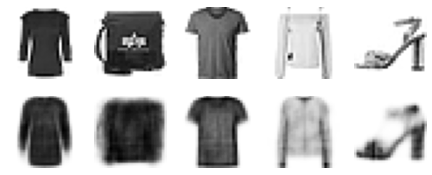

In [36]:
history = variational_ae.fit(X_train, X_train, epochs=50, batch_size=128,validation_data=[X_valid, X_valid])
show_reconstructions(variational_ae)
plt.show()

### 练习：生成Fashion MNIST图像 

现在我们使用VAE来生成类似于Fashion MNIST数据集中图片的图像数据。我们唯一要做的就是从高斯分布中采样，然后再对样本进行解码：

Saving figure vae_generated_images_plot


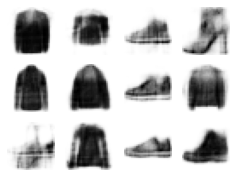

In [37]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])#从高斯分布中采样
images = variational_decoder(codings).numpy()#对样本进行解码

plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

如图，可以看出其中大多数图片看起来还是比较真实的，只是有一些模糊，还有一部分图片效果并没有那么好。但是我们不能对VAE过分苛责，因为它的训练时间只有几分钟，如果我们愿意花费更多时间进行模型微调和训练的话，这些图片看起来会更加真实。

除了常规的数据生成之外，VAE使得语义插值成为可能：与像素级别的图像插值不同（这会导致生成的图像像两个图片的简单重叠），VAE可以实现编码级别的插值。实现方法是，我们首先对两个图片进行编码，然后对我们得到的两个编码进行插值得到新的编码，然后再解码就得到了插值的图片。可以预见到，生成的插值图片会非常类似于Fashion MNIST数据集中的图片，但它本质上是两张数据集中图片的插值结果。在以下的代码示例中，我们首先取出生成的12个编码，然后将其重新组织成$3\times4$的网格，并且使用$\textsf{tf.image.resize()}$函数将其resize成$5\times7$的网格。默认情况下，$\textsf{resize()}$函数会进行双线性插值，因此每隔一行和一列都包含插值编码。然后我们再使用解码器生成图片。

Saving figure semantic_interpolation_plot


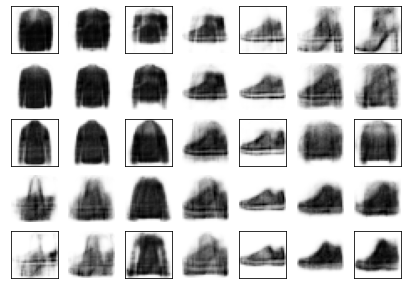

In [38]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

上图显示了语义插值生成的图像。原始图像被框起来，其余的是相邻图像之间语义插值的结果。关注第4行和第5列中的鞋子，它是上下的两个鞋子之间进行插值结果，可以看出插值效果是非常好的。

VAE在表示学习领域流行了很多年，直到GANs的出现。GANs相对于VAE有更强的数据生成能力，尤其在图片生成方面，可以生成更真实清晰，甚至以假乱真的数据图片。

# 生成对抗网络

生成对抗网络于2014年由Ian Goodfellow等人提出，尽管对抗学习的想法在当时非常令人兴奋，但从提出想法到成功训练GANs仍然花费了多年时间。与一些伟大的想法类似，GANs从思想上是简单的：让神经网络相互竞争，以此促进彼此的性能。GANs由两部分组成：
- 生成器（Generator）：输入为一个随机分布（一般是高斯分布），输出为生成的数据（一般是图片）。若将该随机输入视为即将生成的数据的隐含表示，那么生成器与VAE中的解码器的功能是类似的。然而，这两者在训练方法上由很大区别，后续再讲。

- 识别器（Discriminator）：输入为生成器生成的虚假数据或者训练集中的真实数据，输出为输入数据的真假预测。在训练过程中，识别器与生成器的训练目标完全相反：识别器想尽量区分生成器生成的虚假数据与真实数据，而生成器想尽量生成与真实数据相近的虚假数据。

由于GANs的两个组件训练目标完全不同，其训练方式也不同于传统的神经网络。每一步迭代中都包含两个步骤：

- 第一步：训练识别器。输入数据是由一批采样自训练集的真实数据和等量的由生成器生成的虚假数据混合组成。真实数据标签为1，虚假数据标签为0。识别器在这些带标签的数据集上进行一步训练，损失函数是二元交叉熵。注意，此时只更新识别器的权重参数；

- 第二步：训练生成器。首先由生成器再生成一批虚假数据，并由识别器进行判别。注意，此次输入识别器的数据不掺杂任何的真实数据。换句话说，我们希望生成器生成的虚假数据会被识别器识别为真。同样的，这个过程我们仅仅更新生成器的权重参数。

### 示例：在Fashion MNIST数据集上搭建GAN模型

首先，搭建一个生成器与识别器。生成器类似于自编码器的decoder，而识别器则是常规的二元分类器。

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.models.Sequential([generator, discriminator])

接下来对这些模型进行编译。由于识别器是一个二元分类器，我们自然将二元交叉熵作为损失函数。由于生成器是通过$\textsf{gan}$模型进行训练的，因此我们不需要编译生成器，而$\textsf{gan}$同样是一个二元分类器，所以也采用二元交叉熵作为损失函数。重要的是，识别器的参数在第二阶段不应当发生改变，因此在编译$\textsf{gan}$模型之前，我们将其设定为不参与训练。

In [35]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

这里的$\textsf{training loop}$与往常不同，不能直接使用$\textsf{fit()}$方法，因此我们需要编写一个定制的$\textsf{training loop}$。在此之前，我们首先需要创建一个$\textsf{dataset}$在图像数据间进行迭代：

In [36]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

我们现在开始编写$\textsf{training loop}$，并将其封装到$\textsf{training_gan()}$函数中：

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()  
        
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Epoch 1/1


从以上代码中我们也可以清楚看出每一步迭代的两个阶段：
- 第一阶段我们首先将高斯噪声添加到生成器中生成一批假的图片，标记为0，然后混入同样数目的真实图片，标记为1。然后基于此来训练识别器。注意此处我们设定识别器的trainable的属性为True，这仅仅是为了消除Keras会出现的警告：当trainable的之前属性为True，现在属性为False会出现，反过来也是。
- 第二阶段我们向GAN中添加高斯噪声。生成器会首先根据该高斯噪声生成假图片，然后交给识别器来识别。我们期望识别器将假图片识别为真，因此target $y_{2}$设定为1。

下图展示了我们利用搭建的GAN迭代50步后所生成的图片，可以发现，这些加图片看起来已经非常真实了。
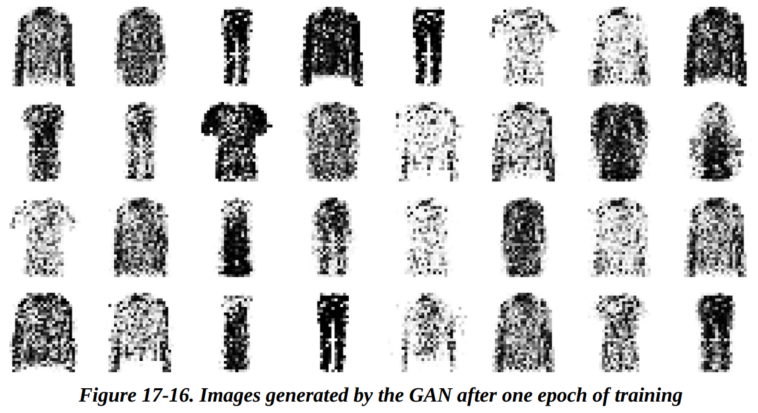

### 训练GANs的困难

在GAN的训练过程中，生成器与识别器本质上是在进行零和博弈，在博弈中尝试比对方表现得更好。而随着训练的进行，博弈会终止在纳什均衡的状态：即没有哪一方可以在对方不改变策略的条件下，通过改变自身的策略使得自身表现更好。

因此，这些问题如何在GANs的训练中体现呢？文章的作者提出GAN只可能达到一个纳什均衡态：即生成器已经可以生成“完全真实的数据”（与训练集数据的分布完全一致，但又不属于训练集），而识别器必须从中进行识别（50%为真，50%为假）。这是令人鼓舞的结果：意味着我们只需要训练GAN足够长时间，它最终就可以达到纳什均衡态，从而生成一个堪称完美的生成器。然而，问题在于，我们谁都无法保证均衡态是可以达到的。具体的困难主要包括以下两种：

- 模式崩溃：即生成器生成的数据缺乏多样性。试想一个生成器生成的鞋子图片比训练集中其他类别的事物更加接近真实，这会使得识别器识别鞋子的准确率更低，从而进一步促使生成器生成更多的鞋子图片。逐渐地，生成器会忘记如何生成除鞋子以外的其他图片，识别器也会忘记如何识别其他类别的图片。直到，识别器能够完全识别出真的鞋子图片和假的鞋子图片，生成器会逐渐迁移到其他类别，然后再变得更加擅长生成T恤衫，忘记如何生成鞋子，识别器也是类似。也就是说，GAN最终会遍历所有的事物类别，却从来无法真正的同时生成每一种类别的图片。

- 训练不稳定：由于生成器和识别器是相互竞争的关系，因此它们的参数最终可能会呈现振荡而不稳定的状态。训练可能在开始的时候没有问题，但是会由于不稳定而迅速变得不收敛。这个不稳定可能是由许多因素导致的，包括超参数的选取，因此，要训练好一个GAN，我们可能需要大量的精力来进行微调。

这些问题自从GAN在2014年提出就困扰着研究人员：许多研究都集中在解决在这些问题，有些研究提出设计新的损失函数，而另一些研究提出新的技巧来稳定训练过程或避免模式崩溃。

简要来说，这里仍然是一个非常活跃的研究领域，而且GANs的动态性还是没有被完全理解。但是好消息是已经取得了巨大的进展，一些研究结果也是令人振奋的！接下来我们简要介绍一些成功的研究，从深度卷积GANs开始，后续再介绍两个最新的框架。

### 深度卷积GANs

2014年提出GAN的paper已经在实验中运用了卷积神经网络，但仅仅用于生成非常小的图片。不久以后，许多研究人员已经开始构建很深的卷积神经网络用于得到很大的图片。这个任务是非常棘手的，因为训练是不稳定的，但是2015年Alec Radford等人在试验过很多框架后还是成功了。他们称自己的框架为深度卷积GANs(Deep Convolutional GANs,DCGANs)。这里是他们对于实现DCGANs的一些指导：

- 用带步长的卷积（在识别器中）和转置卷积（在生成器中）来代替池化层；
- 同时在生成器与识别器中使用批标准化技术；
- 移除深度框架中的全连接隐含层；
- 在生成器中使用ReLu激活函数，在输出层中使用tanh激活函数；
- 在识别器中的所有层使用leaky ReLu激活函数。

这些指导在许多场景中都是奏效的，但并不适用于所有场景。因此你仍然需要用许多不同的超参数来进行实验（事实上，仅仅更改随机种子然后训练相同的模型在有些情况下仍然是可行的）。例如，有一个小的DCGAN在Fashion MNIST数据上表现很好：

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

生成器使用大小为100的编码，然后将其映射到6272维，然后再将其重新reshape成$7\times7\times128$维度的张量。这个张量首先被批量标准化，然后被输入一个步长为2的转置卷积层，这可以将它们下采样

In [8]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

识别器与传统用于二分类的CNN基本相同，除了在传统CNN中利用max pooling层来对图像进行下采样，而在识别器中采用了$stride=2$的卷积层。

整体来讲，我们遵从了DCGAN的指导，除过我们用Dropout层代替了建议的BatchNormalization层，并且在生成器中利用SELU激活函数代替了ReLU函数以外。

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
train_gan(gan, dataset, batch_size, codings_size,n_epochs=1)

最后，为了构建数据集并且编译和训练模型，我们使用与之前完全相同的代码。在50步训练过后，生成器产生了如上所示的图片。同样不算完美，但其中很多图片已经足够以假乱真了。
如上所述，DCGANs不是完美的。比如，当我们想要使用DCGANs来生成非常大的图片数据，我们经常会生成在局部非常可信但整体并不一致的特征（比如说T恤的一条袖子比另一条更长），这样的问题又该怎样解决呢？


### Progressive Growing of GANs

2018年英伟达的研究人员Tero Karras等人提出了一种重要的训练技巧：训练刚开始先生成较小的图片，然后通过逐渐向生成器和识别器添加卷积层生成越来越大的图片。添加的卷积层被添加在生成器的最后以及识别器刚开始的几层。

例如，如下图所示，当试图将生成器的输出从$4\times 4$增长到$8\times 8$时，一个上采样层被添加到现有的卷积层，而后该$8\times 8$的特征图被输入一个新的卷积层。此外，添加的上采样层还会直接后接一个输出卷积层：核大小为1的常规卷积层，负责将$8\times 8$的特征图映射成期望数目的颜色信道（比如，3）。当新的卷积层被加入时，为了避免破坏现有卷积层之前训练好的权重参数，最终的输出设定为原始输出层与新输出层权重参数的加权和。假设新的输出层的权重参数时$\alpha$，原始输出层的权重参数则为$1-\alpha$,我们设定$\alpha$逐渐从$0$增长到$1$。换句话说，新的卷积层权重逐渐加大，同时原始的卷积层权重逐渐减少。当新的卷积层被添加到识别器时也使用同样的技巧（原始卷积层后接一个平均池化层用于下采样）。

![progressive.png](https://raw.githubusercontent.com/private-mechanism/book_translation/master/images/autoencoders/progressively%20growing%20gan.png)

文章中同样引入了一些用于增长输出多样性以及稳定训练过程的技巧。

- 微批标准差层(Minibatch standard deviation layer)。该层被添加到识别器接近最后的位置。功能为：针对输入数据的每一个位置，它都会计算出该微批中所有实例和信道在该位置上的标准差，并对这些标准差进行平均得到一个唯一的值。然后这个值被填充到一个额外的特征图并添加到微批的每一个实例。其作用是，如果生成器生成的图片变化很小（即，多样性不够），那么对应的标准差值也会很小。这个标准差统计量可以帮助识别器识别不具备足够多样性的生成器。这会提高生成器生成图片的多样性，从而避免模式崩溃。

- 等学习率 (Equalized learning rate)。使用均值为0、标准差为1的高斯分布初始化所有权重，而不使用He初始化。然而，在训练过程中，权重参数按照与He初始化设定中相同的比例因子变小：比例因子为$\sqrt{2/n_{inputs}}$，其中$n_{inputs}$是该层输入的数目。文章中表明在使用RMSProp，Adam，或者其它的自适应梯度优化器进行模型训练时，使用这种技巧可以极大提升GAN的性能。事实上，这些优化器都是通过梯度更新标准差的估计来对梯度更新进行标准化的(见第11章)，因此，动态范围较大的参数需要更长的时间来训练，而动态范围较小的参数可能更新得太快，导致不稳定。通过将权重的调整作为模型本身的一部分而不仅仅在初始化时进行调整，这种方法确保了在整个训练过程中所有参数的动态范围都是相同的，因此它们都以相同的速度进行学习。这同时保证了训练的速度和稳定性。

- 像素归一化层(Pixelwise normalization layer)。该层被添加到生成器的每一个卷积层之后。功能为：标准化每一张图片同一个位置关于不同信道间的激活函数值（除以平均激活平方的平方根）。在TensorFlow的代码中，也就是$\textsf{inputs/tf.sqrt(tf.reduce_mean(tf.square(X), axis=-1, keepdims=True)+1e-8)}$（平滑项$1e-8$是为了避免除数为0）。这个技巧可以避免由于生成器和识别器之间过度竞争而产生的“激活爆炸”问题。

通过以上技巧的结合，文章中生成的面部图片质量看起来非常高。然而，到底如何度量生成图片的质量呢？这也是GANs研究中的一个巨大的挑战：尽管自动评估生成图片的多样性是可行的，但对于质量的评估仍然是非常棘手且现实的任务。一种技巧是人们投票决定，但是其成本过高且时间上并不高效。作者们提出度量生成图片与训练集图片局部结构间的相似性，这个想法引导他们实现了另一个突破性的进展：StyleGANs。

### StyleGANs

2018年，英伟达团队引入了StyleGANs用于生成高分辨率的图片，研究人员提出在生成器中使用“style transfer”技巧来确保生成的图片于训练数据有着相同的局部结构，并且在任何尺度上，极大地提升生成图片的质量。StyleGANs由两部分组成;

- 映射网络（Mapping Network）：由一个8层的MLP构成，负责将隐含编码$z$映射到一个向量$w$。这个向量$w$被传递通过多个仿射变换（例如，不包含激活函数的紧密层），从而再产生多个风格向量。这些风格向量包含了生成图片在各个级别的风格，包含细致的纹理到一些高级的概念，比如成人和孩童。
- 合成网络（Synthesis Network）：负责生成图片。合成网络有着恒定的学习输入（需要明确的是，这个输入在训练之后是恒定的，但是在训练期间，它会不断地通过反向传播被改变）。它通过多个卷积层和上采样层来处理输入，但是有两点不同：首先，噪声是被添加到输入与卷积层的所有输出中的；其次，每一个噪声层都会紧跟着一个自适应样例标准化层：负责独立地标准化每一个特征图（通过减去特征图的均值然后再除以标准差），然后再适用风格向量来决定各特征图的比例尺和偏移量（风格向量包含每个特征图的尺度和偏移项）。

![StyleGANs.png](https://raw.githubusercontent.com/private-mechanism/book_translation/master/images/autoencoders/stylegans.png)

将噪声独立地添加到编码中是非常重要的。图片的某些部分是完全随机的，比如每一个雀斑或者发丝的准确位置。在早期的GANs中，这种随机性必须要么来自编码，要么是由生成器本身产生的一些伪随机噪声。如果它来自于编码，这意味着生成器必须将编码表达能力的很大一部分用于存储噪声：这是相当浪费的。此外，噪声必须能够流经网络并到达生成器的最后一层：这个限制可能会减慢训练。最后，可能会出现一些视觉伪影，因为在不同级别使用了相同的噪声。如果生成器试图产生它自己的伪随机噪声，这个噪声可能看起来不是很有说服力，导致更多的视觉伪影。此外，生成器的部分权重将用于产生伪随机噪声，这似乎也是浪费。通过增加额外的噪声输入，所有这些问题都可以避免：GAN能够使用所提供的噪声为图像的每个部分添加适当的随机性。

在StyleGANs中针对每一个级别添加的噪声都是不同的：每一个噪声输入包含了一个满含高斯噪声的特征图，这些噪声在添加之前被广播到每一个特征图并且使用学习到的特征特定的缩放因子进行缩放。

最后，StyleGAN使用了一种称为混合正则化(或风格混合)的技术，即使用两种不同的编码生成一定比例的生成图像。具体来说，编码$c_1$和$c_2$首先通过映射网络生成两个风格向量$w_1$和$w_2$。然后，合成网络根据第一级别的风格$w_1$生成一张图片，剩余级别的风格$w_2$生成一张图片，级别之间的划分是随机选取的。这避免了网络假设相邻级别的风格是相关的，而这又反过来鼓励了GAN中的局部性，意味着每个风格向量只能影响到生成图片中有限数量的特征。
